# References

The following notebook generates coded examples, with some accompanying theory, of some of the statistical methods discussed in the following works:

Bishop, C.M., 2006. Pattern recognition and machine learning. springer.

Rasmussen, C.E. and Williams, C.K., 2006. Gaussian processes for machine learning, MIT press.

Sollich, P., 2004, September. Can Gaussian process regression be made robust against model mismatch?. In International Workshop on Deterministic and Statistical Methods in Machine Learning (pp. 199-210). Springer, Berlin, Heidelberg.

# Curve Fitting

The cell below is code based on pages 6-9 of Bishop, 2006.
Given a set of observation pairs (x,y), we would like to identify the underlying regularity, or function, from which the data were created. For example, we can formulate a generic model which says that our observations y are generated from some function f(x) such that this function performs a mapping of the inputs x, to the ouputs y. i.e: y = f(x). We then presume that the outputs have been corrupted by some small amount of random noise such that y = f(x) + noise.
Regression analysis is a way to learn about the function f(x), where the goal is to replicate the 'unknown' function as closely as possible without over-fitting (i.e making the regression model pass through all the data points such that we are fitting the random noise as well). We shall also see below how sometimes we need relatively complex models in order to learn relatively complex (non-linear) functions.

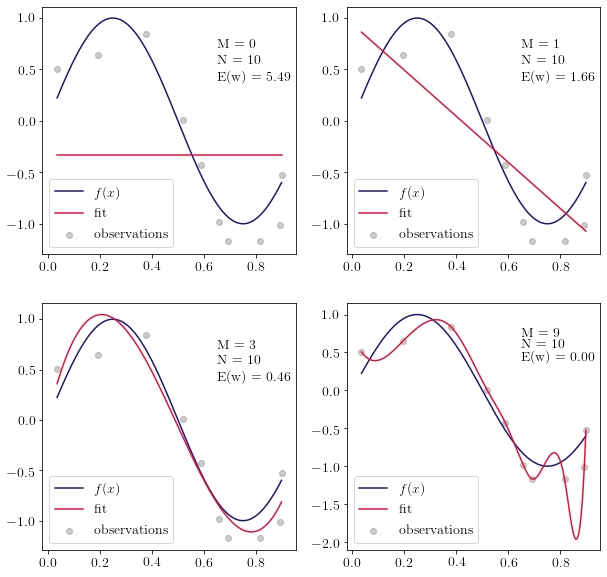

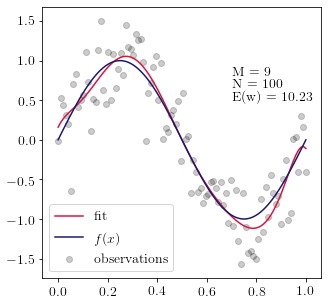

In [32]:
import numpy as np
from numpy.linalg import multi_dot as mdot
import scipy.stats
import scipy.optimize
from scipy.spatial.distance import squareform, pdist, cdist
import matplotlib.pyplot as plt
import os
from funcs import spline

os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2017/bin/x86_64-darwin'
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'cm'
plt.rcParams["font.size"] = 14

np.random.seed(20)

def f(x): #data generating function (in reality we don't know this, but it is what we want to learn)
    return np.sin(2*np.pi*x)

def fit(X):
    L = np.linalg.cholesky(np.dot(X.T,X)) #cholesky decomp is a faster & more stable way of getting a matrix inverse
    w = np.linalg.solve(L.T,np.linalg.solve(L,np.dot(X.T,y))) #closed form solution for w: (x^Tx)^-1x^Ty 
    return np.dot(X,w),np.dot((y - np.dot(X,w)).T,(y - np.dot(X,w)))

N = 10 #number of observations
sn2 = 0.3 #noise variance
x = np.array(sorted(np.random.uniform(0,1,N)))
fx = f(x)
y = fx + np.random.normal(0,sn2,N)
ys = np.zeros((N,4))
Ew = np.zeros(4)

ys[:,0],Ew[0] = fit(np.ones(N).reshape(N,1)) #M = 0, i.e. the order of the polynomial fit.
ys[:,1],Ew[1] = fit(np.array([np.ones(N),x]).T) #M = 1
ys[:,2],Ew[2] = fit(np.array([np.ones(N),x,x**2,x**3]).T) #M = 3
ys[:,3],Ew[3] = fit(np.array([np.ones(N),x,x**2,x**3,x**4,x**5,x**6,x**7,x**8,x**9]).T) #M = 9

x_smooth = np.linspace(x.min(),x.max(),200)
fx_smooth = f(x_smooth)
y_smooth = np.zeros((200,4))
for c in range(4):
    y_smooth[:,c] = spline(x,ys[:,c],x_smooth)

M = [0,1,3,9] #these correspond to the number of polynomial basis functions (see the code on Basis functions below)
fig,ax = plt.subplots(2,2,figsize=(10,10))
axes = [[0,0],[0,1],[1,0],[1,1]]
for c in range(4):
    ax[axes[c][0],axes[c][1]].scatter(x,y,color='k',alpha=0.2, label='observations')
    ax[axes[c][0],axes[c][1]].plot(x_smooth,fx_smooth,color='midnightblue',label='$f(x)$')
    ax[axes[c][0],axes[c][1]].plot(x_smooth,y_smooth[:,c],color='crimson',label='fit')
    ax[axes[c][0],axes[c][1]].text(0.65,0.7,'M = '+str(M[c]))
    ax[axes[c][0],axes[c][1]].text(0.65,0.55,'N = '+str(N))
    ax[axes[c][0],axes[c][1]].text(0.65,0.40,'E(w) = '+str('%.2f' % Ew[c]))
    ax[axes[c][0],axes[c][1]].legend(loc='lower left')
plt.show()

#We can see that for the scenario where M = 0, or M = 1, the model is under-fitting the function f(x). For M = 9 it
#is dramatically overfitting, and passes through each training point so E(w) = 0.
#Now let's plot the same function but increase the number of training points from 10 to 100:

N = 100 #number of observations
x = np.linspace(0,1,N)
fx = f(x)
y = fx + np.random.normal(0,sn2,N)
X = np.array([np.ones(N),x,x**2,x**3,x**4,x**5,x**6,x**7,x**8,x**9]).T
fig,ax = plt.subplots(1,figsize=(5,5))
plt.plot(x,yf(X)[0],color='crimson',label='fit')
plt.scatter(x,y,color='k',alpha=0.2,label='observations')
plt.plot(x,fx,color='midnightblue',label='$f(x)$')
plt.text(0.7,0.8,'M = 9')
plt.text(0.7,0.65,'N = '+str(N))
plt.text(0.7,0.50,'E(w) = '+str('%.2f' % yf(X)[1]))
plt.legend(loc='lower left')
plt.show()



# Regularisation

The cell below is code based on pages 10-11 of Bishop, 2006.
Regularisation aims to control over-fitting (fitting a model to noise, e.g. M=9,N=10 in the plots above) by introducing a penalty term to the least squares error function, such that: E(w) = || y - x^Tw ||^2 + λ||w||^q. λ is the regularisation coefficient and controls the relative importance of the two terms in E(w) above. if q == 1 (L1 norm - diamond penalty zone) then this is known as 'Lasso' regression, and if q == 2 (L2 norm - circular penalty zone) then it is the quadratic regulariser known as 'Ridge' regression. If λ is sufficiently large then some of the coefficients in w are driven to zero in Lasso, or near zero in Ridge, leading to a sparse model in which the corresponding basis functions play no role.


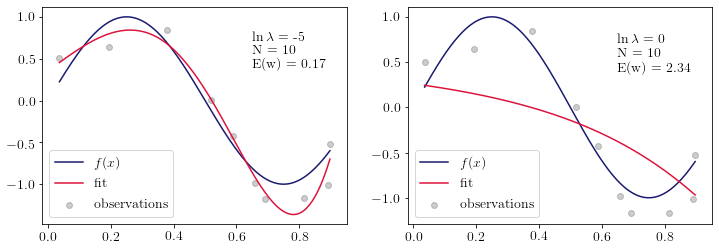

In [34]:
import numpy as np
from numpy.linalg import multi_dot as mdot
import scipy.stats
import scipy.optimize
from scipy.spatial.distance import squareform, pdist, cdist
import matplotlib.pyplot as plt
import os
from funcs import spline

os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2017/bin/x86_64-darwin'
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'cm'
plt.rcParams["font.size"] = 14

np.random.seed(20)

def f(x): #data generating function
    return np.sin(2*np.pi*x)

def fit(X,λ): #ridge regression (note that Lasso does not have an equivalent closed form expression)
    L = np.linalg.cholesky(np.dot(X.T,X) + λ*np.eye(N)) 
    w = np.linalg.solve(L.T,np.linalg.solve(L,np.dot(X.T,y)))
    return np.dot(X,w),np.dot((y - np.dot(X,w)).T,(y - np.dot(X,w)))

N = 10 #number of observations
sn2 = 0.3 #noise variance
x = np.array(sorted(np.random.uniform(0,1,N)))
fx = f(x)
y = fx + np.random.normal(0,sn2,N)
ys = np.zeros((N,2))
Ew = np.zeros(2)

ys[:,0],Ew[0] = fit(np.array([np.ones(N),x,x**2,x**3,x**4,x**5,x**6,x**7,x**8,x**9]).T,λ=np.exp(-10))
ys[:,1],Ew[1] = fit(np.array([np.ones(N),x,x**2,x**3,x**4,x**5,x**6,x**7,x**8,x**9]).T,λ=np.exp(0))

x_smooth = np.linspace(x.min(),x.max(),200)
fx_smooth = f(x_smooth)
y_smooth = np.zeros((200,2))
for c in range(2):
    y_smooth[:,c] = spline(x,ys[:,c],x_smooth)

fig,ax = plt.subplots(1,2,figsize=(12,4))
λs = [-5,0]
for c in range(2):
    ax[c].scatter(x,y,color='k',alpha=0.2,label='observations')
    ax[c].plot(x_smooth,fx_smooth,color='midnightblue',label='$f(x)$')
    ax[c].plot(x_smooth,y_smooth[:,c],color='crimson',label='fit')
    ax[c].text(0.65,0.7,'$\ln\lambda$ = '+str(λs[c]))
    ax[c].text(0.65,0.55,'N = '+str(N))
    ax[c].text(0.65,0.40,'E(w) = '+str('%.2f' % Ew[c]))
    ax[c].legend(loc='lower left')
plt.show()


# Basis Functions

Basis functions are a way to overcome the limitations of a linear model x^Tw by projecting the inputs into some high dimensional feature space, and then applying the same linear equations there, rather than directly on the inputs themselves. As long as the projections are fixed functions, the model is still linear in the parameters and so analytically tractable. Therefore by using non-linear basis functions we can capture non-linear relationships in f(x)... such as sin(2πx)

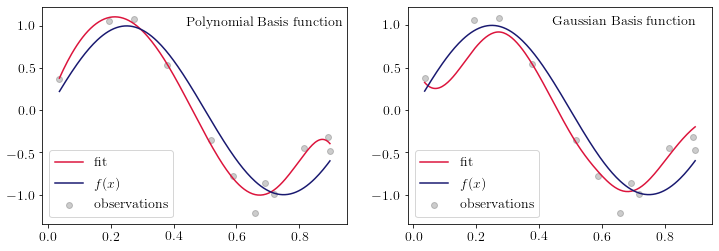

In [35]:
import numpy as np
from numpy.linalg import multi_dot as mdot
import scipy.stats
import scipy.optimize
from scipy.spatial.distance import squareform, pdist, cdist
import matplotlib.pyplot as plt
import os
from funcs import spline

os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2017/bin/x86_64-darwin'
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'cm'
plt.rcParams["font.size"] = 14

np.random.seed(20)

def f(x): #data generating function
    return np.sin(2*np.pi*x)

def fit(X,λ):
    L = np.linalg.cholesky(np.dot(X.T,X) + λ*np.eye(X.shape[1]))
    w = np.linalg.solve(L.T,np.linalg.solve(L,np.dot(X.T,y)))
    return np.dot(X,w),np.dot((y - np.dot(X,w)).T,(y - np.dot(X,w)))

N = 12 #number of observations
sn2 = 0.3 #noise variance
x = np.array(sorted(np.random.uniform(0,1,N)))
x_smooth = np.linspace(x.min(),x.max(),200)
fx = f(x)
fx_smooth = f(x_smooth)
y = fx + np.random.normal(0,sn2,N)

#we have already seen examples of Basis functions in the code above (on curve fitting and regularisation).
#for example:

ϕ = np.array([np.ones(N),x,x**2,x**3,x**4,x**5,x**6,x**7,x**8,x**9]).T
yPoly = spline(x,fit(ϕ,λ=np.exp(-10))[0],x_smooth)
#here we project the scalar input x into a space of powers, so ϕ becomes a polynomial basis function.
#this enabled us to fit a model to a sine function, despite using a linear model x^Tw.

#Alternatively we could project the input into a series of M Gaussian basis functions:
M = 10
ell = 0.1
ϕ = np.zeros((N,M+1))
ϕ[:,0] = np.ones(N)
mu = np.random.rand(M)
for m in range(M):
    ϕ[:,m+1] = np.exp(-(x-mu[m])**2/(2*(ell**2)))
yGauss = spline(x,fit(ϕ,λ=np.exp(-0.31))[0],x_smooth)

fig,ax = plt.subplots(1,2,figsize=(12,4))
data = [yPoly,yGauss] ; captions = ['Polynomial','Gaussian']
for c in range(2):
    ax[c].scatter(x,y,color='k',alpha=0.2,label='observations')
    ax[c].plot(x_smooth,data[c],color='crimson',label='fit')
    ax[c].plot(x_smooth,fx_smooth,color='midnightblue',label='$f(x)$')
    ax[c].text(0.44,1,captions[c]+' Basis function')
    ax[c].legend(loc='lower left')
plt.show()


# Maximum Likelihood and Bias

The cell below is code based on pages 26-30 of Bishop, 2006. Showing how maximum likelihood can
be a way to recover the parameters of a distribution given enough samples. And how maximum likelihood is equivalent to minimizing the sum of the squares in the context of curve fitting with a Gaussian noise distribution.

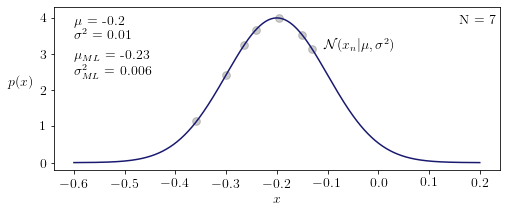

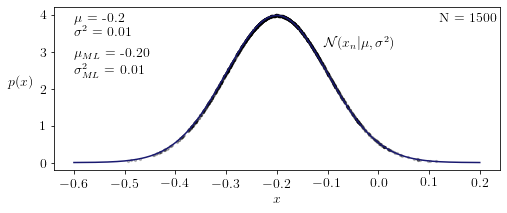

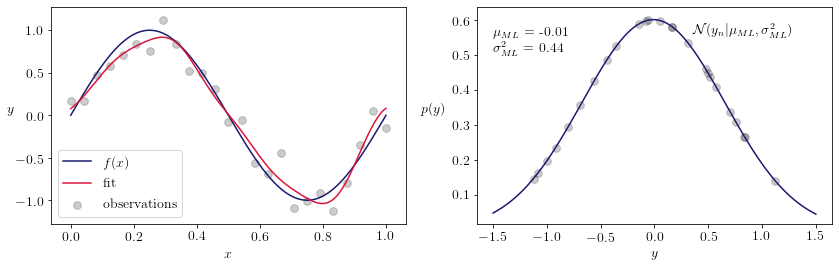

In [78]:
import numpy as np
from numpy.linalg import multi_dot as mdot
import scipy.stats
import scipy.optimize
from scipy.spatial.distance import squareform, pdist, cdist
import matplotlib.pyplot as plt
import os
from funcs import spline

os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2017/bin/x86_64-darwin'
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'cm'
plt.rcParams["font.size"] = 14

np.random.seed(4)

#draw data samples from an 'unknown' normal distribution
N = 7
mu_true = -0.2
var_true = 0.01
sd_true = var_true**0.5
x = np.random.normal(mu_true,sd_true,N)
px = 1/(np.sqrt(2*np.pi)*sd_true)*np.exp(-.5*((x-mu_true)/sd_true)**2) #likelihood of observation samples
px_true = 1/(np.sqrt(2*np.pi)*sd_true)*np.exp(-.5*((np.linspace(-.6,.2,1000)-mu_true)/sd_true)**2) #true likelihood

#now we want to recover mu_true and var_true from the data by maximising (minimising) the 
#(negative) log likelihood function:

def negloglike(parameters,x): #eq 1.54 Bishop,2006
    mu = parameters[0] ; var = np.exp(parameters[1]) ; N = len(x)
    return 1/(2*var) * np.sum((x - mu)**2) + .5*N*np.log(var) + .5*N*np.log(2*np.pi)

#Because the logarithm is a monotonically increasing function of its argument, maximisation of the log of a
#function is equivalent to maximisation of the function itself. Maximising negloglike with respect to mu gives:
mu_ML = np.mean(x) #eq 1.55 Bishop,2006
#and similarly maximising with respect to the variance gives:
var_ML = np.mean((x-mu_ML)**2) #eq 1.56 Bishop,2006
#see how the above is equivalent to using a optimisation algorithm:
param_opt = scipy.optimize.minimize(negloglike,x0=[0,np.log(0.1)],args=(x))
mu_ML_opt = param_opt.x[0]
var_ML_opt = np.exp(param_opt.x[1])
#mu_ML ~ mu_ML_opt ; var_ML ~ var_ML_opt

fig,ax = plt.subplots(1,figsize=(8,3))
plt.plot(np.linspace(-.6,.2,1000),px_true,color='midnightblue')
plt.scatter(x,px,color='k',alpha=0.2,s=60)
plt.xlabel('$x$')
plt.ylabel('$p(x)$',rotation=0,labelpad=20)
plt.text(-0.11,3.1,'$\mathcal{N}(x_n|\mu,\sigma^2)$')
plt.text(-0.6,3.8,'$\mu$ = '+str(mu_true))
plt.text(-0.6,3.4,'$\sigma^2$ = '+str(var_true))
plt.text(-0.6,2.8,'$\mu_{ML}$ = '+str('%.2f'%mu_ML))
plt.text(-0.6,2.3,'$\sigma^2_{ML}$ = '+str('%.3f'%var_ML))
plt.text(0.16,3.8,'N = '+str(N))
plt.show()

#we can see how the variance is under-estimated with maximum likelihood because the variance is measured
#relative to the sample mean and not the true mean. This is known as bias. Also, in this case due to the small
#number of samples the mean over-estimated

#let's consider more observations and see how our estimate of the mean and variance changes:
N = 1500
x = np.random.normal(mu_true,sd_true,N)
px = 1/(np.sqrt(2*np.pi)*sd_true)*np.exp(-.5*((x-mu_true)/sd_true)**2)
mu_ML = np.mean(x)
var_ML = np.mean((x-mu_ML)**2)

fig,ax = plt.subplots(1,figsize=(8,3))
plt.plot(np.linspace(-.6,.2,1000),px_true,color='midnightblue')
plt.scatter(x,px,color='k',alpha=0.2,s=5)
plt.xlabel('$x$')
plt.ylabel('$p(x)$',rotation=0,labelpad=20)
plt.text(-0.11,3.1,'$\mathcal{N}(x_n|\mu,\sigma^2)$')
plt.text(-0.6,3.8,'$\mu$ = '+str(mu_true))
plt.text(-0.6,3.4,'$\sigma^2$ = '+str(var_true))
plt.text(-0.6,2.8,'$\mu_{ML}$ = '+str('%.2f'%mu_ML))
plt.text(-0.6,2.3,'$\sigma^2_{ML}$ = '+str('%.2f'%var_ML))
plt.text(0.12,3.8,'N = '+str(N))
plt.show()

#with enough observations ML, on average, will obtain the correct mean of the distribution, 
#as well as the true variance. For small N, ML under-estimates the true variance by a factor (N-1)/N.

#CURVE FITTING RE-VISITED
#Now let's return to a curve fitting example under the assumption of a Gaussian noise distribution, such that
#for a given value of x; the corresponding value of y has a Gaussian distribution with mean equal to f(x,w)
#and variance equal to sn2.

#Substituting for the form of a Gaussian distribution, we obtain the (negative) log likelihood function as:
def negloglike(parameters,x,y): #eq 1.62 Bishop,2006
    var = np.exp(parameters[0]) ; w = parameters[1:] ; N = len(x)
    return 1/(2*var) * np.dot((y - np.dot(x,w)).T,(y - np.dot(x,w))) - .5*N*np.log(1/(var)) + .5*N*np.log(2*np.pi)
    
#maximising the expression above with respect to the regression parameters w, means we can neglect the last 2 terms
#as they do not depend on w. Also the positive scaling consant 1/(2*var) does not alter the location of the maximum
#at which point we can see that maximisation of the log likelihood is equivalent to minimising the sum of the squares
#error function: 1/2 * np.dot((y - np.dot(x,w)).T,(y - np.dot(x,w))). We can therefore use ML (least-squares) to
#estimate the mean (w_ML) and variance (var_ML) of the likelihood distribution. Let's try an example using the 
#example of y = f(x) + noise, where f(x) = sin(2*np.pi*x):

def f(x): #data generating function
    return np.sin(2*np.pi*x)

def fit(X):
    L = np.linalg.cholesky(np.dot(X.T,X))
    w = np.linalg.solve(L.T,np.linalg.solve(L,np.dot(X.T,y)))
    return np.dot(X,w),np.dot((y - np.dot(X,w)).T,(y - np.dot(X,w)))

N = 25 #number of observations
M = 8 #number of basis functions
ell = 0.1 #length scale of Gaussian basis function
sn2 = 0.2 #variance
x = np.linspace(0,1,N)
x_smooth = np.linspace(0,1,200)
fx = f(x)
fx_smooth = f(x_smooth)
y = fx + np.random.normal(0,sn2,N)
ϕ = np.zeros((N,M+1))
ϕ[:,0] = np.ones(N)
mu = np.random.rand(M)
for m in range(M):
    ϕ[:,m+1] = np.exp(-(x-mu[m])**2/(2*(ell**2))) #Gaussian basis function

#the mean of our fit then equates to the mean of the likelihood distribution:
mu_ML = np.mean(fit(ϕ)[0])
#and also the variance:
var_ML = (fit(ϕ)[1])
sd_ML = var_ML**.5
py = 1/(np.sqrt(2*np.pi)*sd_ML)*np.exp(-.5*((y-mu_ML)/sd_ML)**2) #likelihood distribution
py_ML = 1/(np.sqrt(2*np.pi)*sd_ML)*np.exp(-.5*((np.linspace(-1.5,1.5,200)-mu_ML)/sd_ML)**2) 

fig,ax = plt.subplots(1,2,figsize=(14,4))
for c in range(2):
    if c == 0:
        ax[c].plot(x_smooth,fx_smooth,color='midnightblue',label='$f(x)$')
        ax[c].scatter(x,y,color='k',alpha=0.2,s=60,label='observations')
        ax[c].plot(x_smooth,spline(x,fit(ϕ)[0],x_smooth),color='crimson',label='fit')
        ax[c].set_xlabel('$x$')
        ax[c].set_ylabel('$y$',rotation=0,labelpad=5)
        ax[c].legend(loc='lower left')
    if c == 1:
        ax[c].plot(np.linspace(-1.5,1.5,200),py_ML,color='midnightblue')
        ax[c].scatter(y,py,color='k',alpha=0.2,s=60)
        ax[c].set_xlabel('$y$')
        ax[c].set_ylabel('$p(y)$',rotation=0,labelpad=20)
        ax[c].text(0.35,0.55,'$\mathcal{N}(y_n|\mu_{ML},\sigma^2_{ML})$')
        plt.text(-1.5,.55,'$\mu_{ML}$ = '+str('%.2f'%mu_ML))
        plt.text(-1.5,.5,'$\sigma^2_{ML}$ = '+str('%.2f'%var_ML))
plt.show()

#then for new values for x we can make predictions of of y with uncertainty as we have a probabilistic model.
#we simply evaluate the value of y based on the new value of x using our learnt function. and then generate a
#distribution using the maximum likelihood values of the mean and variance which we learnt earlier.

# Bias-Variance tradeoff

The cell below is code based on pages 149 - 151 of Bishop, 2006.
As we have seen above, sometimes we need a relatively complex model (e.g high number of basis functions) to accurately fit a complex (i.e non-linear) model. However, how do we choose the right number of basis functions without over- or under-fitting? We have also seen that regularisation is a way to overcome over-fitting problems, however trying to derive the optimal values of both w and λ which minimise the error function (or maximise the likelihood) is not suitable as this just leads to λ = 0. Over-fitting is really just an unfortunate property of maximum likelihood methods. Here we show some examples of the inherent struggle of frequentist model fitting exercises, where we must reach a tradeoff between accurately estimating the function from which our observations were generated (i.e a low bias), and achieving a consistently similar model between data sets (low variance).
Think of it like bias = accuracy and variance = precision.

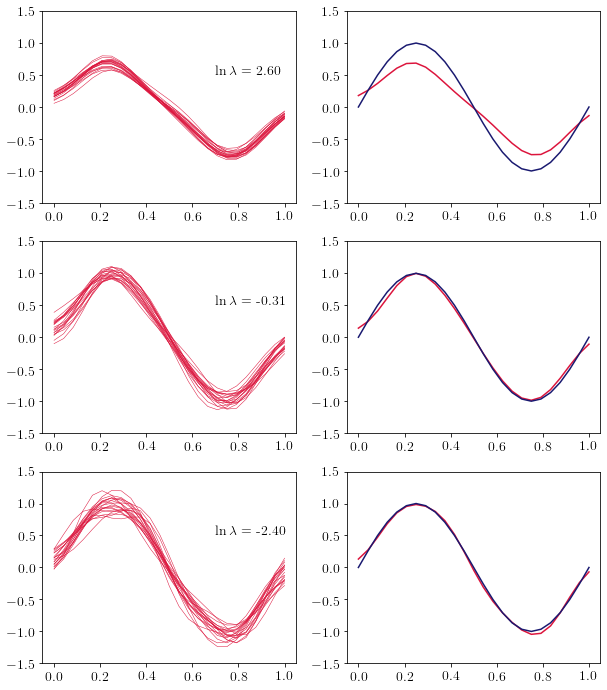

In [27]:
import numpy as np
from numpy.linalg import multi_dot as mdot
import scipy.stats
import scipy.optimize
from scipy.spatial.distance import squareform, pdist, cdist
import matplotlib.pyplot as plt
import os
from funcs import spline

os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2017/bin/x86_64-darwin'
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'cm'
plt.rcParams["font.size"] = 14

np.random.seed(20)

def f(x): #data generating function
    return np.sin(2*np.pi*x)

#here we draw 20 i.i.d different data sets, each with 25 observations, from the same function sin(2pix) + noise.
#the aim is to use these data sets to estimate the 'unknown' function sin(2pix) using regression.
#Here we generate 3 different models in attempt to best fit this function. Each model is constructed using 24 Gaussian
#basis functions, and ridge regression is performed for the fitting. The difference is that each of the three models
#uses a different regularisation coefficient λ

N = 25 #number of observations
M = 24 #number of basis functions
D = 20 #number of data sets
s = 0.1 #length scale of Gaussian basis function
sn2 = 0.2 #noise variance
λs = [np.exp(2.6),np.exp(-0.31),np.exp(-2.4)]
x = np.linspace(0,1,N)
fx = f(x)
ϕ = np.zeros((N,M+1))
ϕ[:,0] = np.ones(N)
mu = np.random.rand(M)
for m in range(M):
    ϕ[:,m+1] = np.exp(-(x-mu[m])**2/(2*(s**2))) #Gaussian basis function
ys = np.zeros((len(λs),L,N))
count = 0
for λ in λs:
    L = np.linalg.cholesky(np.dot(ϕ.T,ϕ) + λ*np.eye(N))
    for d in range(D):
        y = f(x) + np.random.normal(0,sn2,N)
        w = np.linalg.solve(L.T,np.linalg.solve(L,np.dot(ϕ.T,y)))
        ys[count,d,:] = np.dot(w,ϕ.T)
    count += 1

fig,ax = plt.subplots(3,2,figsize=(10,12))
for ix in range(3):
    for jx in range(2):
        if jx == 0:
            ax[ix,jx].plot(x,ys[ix,:,:].T,color='crimson',lw=.5)
            ax[ix,jx].set_ylim(-1.5,1.5)
            ax[ix,jx].text(0.7,0.5,'$\ln\lambda$ = '+str('%.2f' % np.log(λs[ix])))
        else:
            ax[ix,jx].plot(x,np.mean(ys[ix,:,:],axis=0),color='crimson')
            ax[ix,jx].plot(x,fx,color='midnightblue')
            ax[ix,jx].set_ylim(-1.5,1.5)
plt.show()

#the plots on the left show the fits for each of the 20 different data sets, for each of the 3 models. We can see
#that where lnλ = 2.6, the models are relatively well grouped (similar). i.e they have low VARIANCE, whereas the
#model with lnλ = -0.31 and lnλ = -2.4 show increasing amounts of variance between fits. 
#The plots on the right then show the average of each of the corresponding model fits for all 20 data sets. Here we
#can see that while lnλ = 2.6 has low VARIANCE it has the highest BIAS as it does not accurately estimate the data
#generating function (blue). Whereas the model with the largest VARIANCE (lnλ = -2.4) shows the lowest
#BIAS, in that the average of all the fits accurately respresents sin(2pix).

#N.B "Although the bias-variance decomposition may provide some interesting insights into the model complexity issue
#from a frequentist perspective, it is of limited practical value, because the bias-variance decomposition is based
#on averages with respect to ensembles of data sets, whereas in practice we have only the single observed data set."


# Bayesian Linear Regression

This cell below is code based on pages 154-155 of Bishop, 2006, and pages 8-12 of Rasmussen and Williams, 2006.
The Bayesian approach is centered around updating prior beliefs in the presence of new information/data. In the linear regression problem, we place a prior belief over the distribution of the regression weights p(w) ~ N(μ_prior,Σ_prior) before seeing any observations. Upon seeing the observations we determine the likelihood of the observations, given the regression parameters, factored over the training set: p(y|x,w) ~ N(x^Tw,σ^2I). We then use Bayes' Law to derive a posterior distribution for the regression weights, which means we get uncertainty estimates on w for free: p(w|y,x) ~ N(((x^Tx/σ^2 + Σ_prior)^-1x^Ty)/σ^2,(x^Tx/σ^2 + Σ_prior)^-1).
Bayesian linear regression avoids the over-fitting problem encountered in maximum likelihood methods and leads to automatic methods for determining model complexity using the training data alone (i.e do not need to use indepdent hold out data).



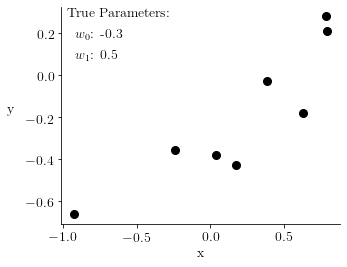

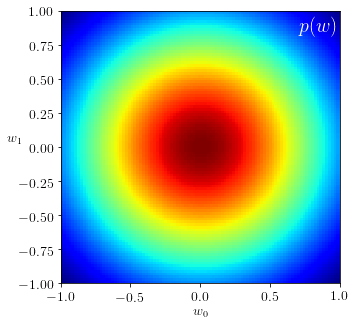

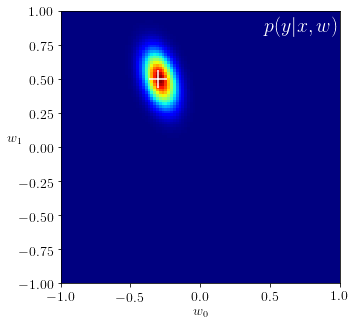

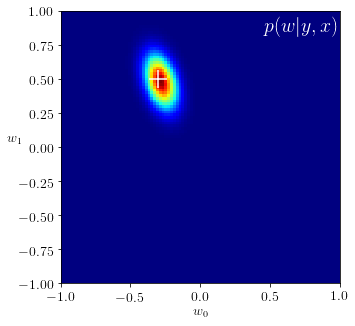

In [58]:
import numpy as np
from numpy.linalg import multi_dot as mdot
import scipy.stats
import scipy.optimize
from scipy.spatial.distance import squareform, pdist, cdist
import matplotlib.pyplot as plt
import os
from funcs import spline

os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2017/bin/x86_64-darwin'
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'cm'
plt.rcParams["font.size"] = 14

np.random.seed(20)

#CREATE LINEAR TRAINING DATA, THE 'UNKNOWN' PARAMETERS OF WHICH WE WISH TO LEARN
w0_true = -0.3
w1_true = 0.5
N = 8
M = 100
sn2 = 0.2
x = np.random.uniform(-1,1,N)
noise = np.random.normal(0,sn2,N)
w0_samples = np.linspace(-1,1,M)
w1_samples = np.linspace(-1,1,M)
w0,w1 = np.meshgrid(w0_samples,w1_samples)

y = (w0_true + x*w1_true) + noise

#PLOT TRAINING DATA
fig,ax = plt.subplots(1,figsize=(5,4))
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.plot(x,y,'k.',markersize=16)
ax.set_xlabel('x')
ax.set_ylabel('y', rotation=0, labelpad=15)
ax.text(0.02,0.95, 'True Parameters:', transform=ax.transAxes)
ax.text(0.05,0.85, '$w_0$: -0.3', transform=ax.transAxes)
ax.text(0.05,0.75, '$w_1$: 0.5', transform=ax.transAxes)
plt.show()

#PLOT ISOTROPIC GAUSSIAN PRIOR DISTRIBUTION (see e.g eq 2.4 Rasmussen and Williams, 2006)
prior = scipy.stats.multivariate_normal([0, 0], [[0.5, 0], [0, 0.5]]) #zero mean and zero covariance (only variance)
pos = np.empty(w0.shape + (2,))
pos[:, :, 0] = w0 ; pos[:, :, 1] = w1
fig,ax = plt.subplots(1,figsize=(5,5))
plt.pcolor(w0,w1,prior.pdf(pos), cmap='jet')
plt.xlabel('$w_0$') ; plt.ylabel('$w_1$', rotation=0)
plt.ylim(-1,1,0.5)
plt.text(0.7,0.85,'$p(w)$',fontsize=20,color='white')
plt.show()

#PLOT LIKELIHOOD (see e.g eq 2.3 Rasmussen and Williams, 2006)
constant = 1/((2*np.pi*sn2**2)**1/2)
likelihood = np.zeros((M,M))
X = np.asarray([np.ones(N),x]).T
for ix in range(M):
    for jx in range(M):
        w = np.asarray([w0[ix,jx],w1[ix,jx]])
        like = []
        for n in range(N):
            like.append(constant * np.exp(-((y[n] - np.dot(X[n],w))**2)/(2*sn2**2)))
        likelihood[ix,jx] = np.prod(like)
fig,ax = plt.subplots(1,figsize=(5,5))
plt.pcolor(w0,w1,likelihood, cmap='jet')
plt.xlabel('$w_0$') ; plt.ylabel('$w_1$', rotation=0)
plt.ylim(-1,1,0.5)
plt.scatter(w0_true,w1_true, marker='+',color='white', s=300)
plt.text(0.45,0.85,'$p(y|x,w)$',fontsize=20,color='white')
plt.show()

#PLOT POSTERIOR (see e.g eq 2.5 Rasmussen and Williams, 2006)
posterior = (likelihood * prior.pdf(pos))/(np.nansum(likelihood*prior.pdf(pos))) #Bayes' Law
fig,ax = plt.subplots(1,figsize=(5,5))
plt.pcolor(w0,w1,posterior, cmap='jet')
plt.xlabel('$w_0$') ; plt.ylabel('$w_1$', rotation=0)
plt.ylim(-1,1,0.5)
plt.scatter(w0_true,w1_true, marker='+',color='white', s=300)
plt.text(0.45,0.85,'$p(w|y,x)$',fontsize=20,color='white')
#plt.colorbar()
plt.show()

#In practice we wouldn't perform BLR like the above. Let's do an example of a practical implementation:
N = 8
X = np.asarray([np.ones(N),x]).T #use same data as previously but augment x with a vector of 1s (for the bias term)
sn2 = 0.2
M = 2 #there are 2 parameters we want to learn, the gradient and the bias term.

#define the prior w ~ N(0,Σ_prior) eq 2.4 Rasmussen and Williams, 2006
μ_prior = np.zeros(M) #zero mean prior 
Σ_prior = np.eye(M)*0.5 #prior covariance matrix
y_ = y - np.dot(X,μ_prior) #compute this here for convenience

#Compute based on equation 2.11 of Rasmussen and Williams, 2006
A = (1/sn2)*np.dot(X.T,X) + np.diag(1/Σ_prior.diagonal()) #inverse of a diagonal matrix = 1/diagonal_elements
L = np.linalg.cholesky(A) #more stable & faster way of getting an inverse matrix than np.linalg.inv()
μ_posterior1 = μ_prior + (1/sn2)*np.linalg.solve(L.T,np.linalg.solve(L,np.dot(X.T,y_)))
#note that the above expression is essentially written as (sn2^-1X^TX + Σ_prior^-1)^-1X.Ty.
#The posterior of the regression weights is given by: p(w|y,X) \propto exp(-1/2*sn2 * (y-Xw)^2) * exp(-w^TΣ_priorw/2)
#If we maximise the logarithm of the posterior distribution with respect to w, then this is equivalent to the 
#minimisation of the sum of squares error function with an additional quadratic penalty term, i.e Ridge Regression.
#In ridge regression the quadratic penalty is λw^Tw/2. In BLR it is w^TΣ_priorw/2sn2
Σ_posterior1 = np.linalg.solve(L.T,np.linalg.solve(L,np.eye(M))) #covariance matrix of the posterior distribution

#Compute equivalent way based on equation 2.12 of Rasmussen and Williams, 2006
K = mdot([X,Σ_prior,X.T]) + sn2*np.eye(N) #this is our linear kernel function (Gram matrix)
L = np.linalg.cholesky(K) 
α1 = np.linalg.solve(L.T,np.linalg.solve(L,y_))
α2 = np.linalg.solve(L.T,np.linalg.solve(L,np.dot(X,Σ_prior)))

μ_posterior2 = μ_prior + mdot([Σ_prior,X.T,α1]) #mean of the posterior distribution
Σ_posterior2 = Σ_prior - mdot([Σ_prior,X.T,α2]) #covariance matrix of the posterior distribution


# Gaussian Process Regression (Kriging)

The cell below is code based on pages 13-16 of Rasmussen and Williams,2006.
Gaussian process regression is a Bayesian inference technique which can be thought of as the 'function space' approach to Bayesian linear regression. In this sense, GPR does away with the parametric model setup from BLR (i.e the regression weights w) and instead moves towards fully non-parametric models and allows for non-linear fits - N.B that BLR does also allow for non-linear fits if we map the inputs to high dimensional feature spaces using basis functions. Recalling the model y = f(x) + noise; in BLR we placed a prior over the regression weights p(w) as f(x) = x^Tw. In the non-parametric GPR approach the equivalent to p(w) is a prior over the function f(x) directly. Then, a prior with zero-mean can be fully specified by its covariance between the function values for two arbitrary inputs: f(x)f(x') = k(x,x') = K(X,X). From this prior one obtains a posterior over functions in the form: p(fs|X,y,Xs) ~ N(K(Xs,X){K(X,X) + σ^2I}^-1y,K(Xs,Xs)-K(Xs,X){K(X,X) + σ^2I}^-1K(X,Xs)). Where (X,y) are training inputs and Xs are test inputs.

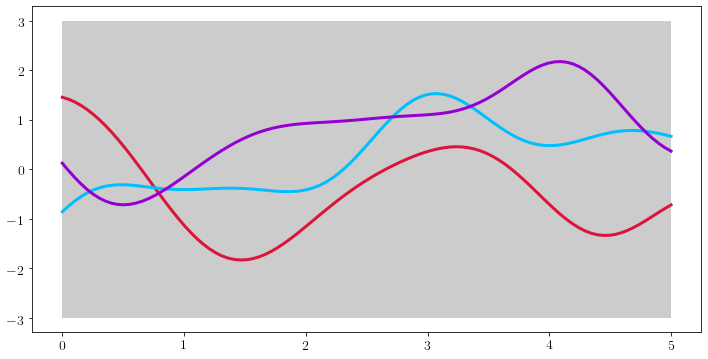

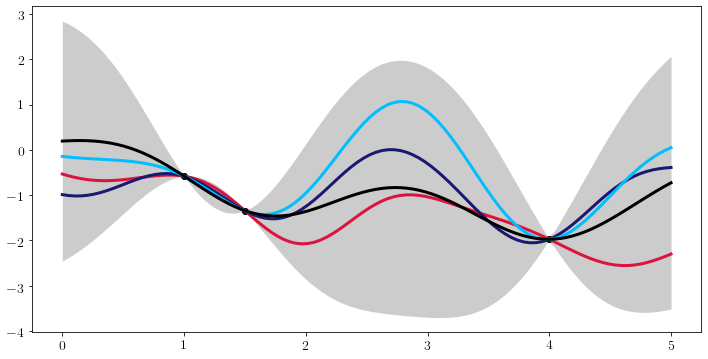

In [2]:
import numpy as np
from numpy.linalg import multi_dot as mdot
import scipy.stats
import scipy.optimize
from scipy.spatial.distance import squareform, pdist, cdist
import matplotlib.pyplot as plt
import os
from funcs import spline

os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2017/bin/x86_64-darwin'
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'cm'
plt.rcParams["font.size"] = 14

np.random.seed(20)

def f(x): #prior
    k = sf2 * np.exp(-.5*squareform(pdist(x,'sqeuclidean')/ell))
    m = np.zeros(len(x))
    return np.random.multivariate_normal(m,k)

def fs(x,xs): #posterior
    kx = sf2 * np.exp(-.5*squareform(pdist(x,'sqeuclidean')/ell))# + np.eye(n)*sn2
    kxs = sf2 * np.exp(-.5*cdist(xs,x,'sqeuclidean')/ell)
    kss = sf2 * np.exp(-.5*squareform(pdist(xs,'sqeuclidean')/ell))
    k = kss - mdot([kxs,np.linalg.inv(kx),kxs.T])
    m = mdot([kxs,np.linalg.inv(kx),y])
    return np.random.multivariate_normal(m,k)

n = 3 #training points
ns = 100 #test points
sf2 = 1 #signal variance (hyperparameter)
ell = 0.5 #length scale (hyperparameter)
sn2 = 0.1 #noise variance (we are going to assume noise free for now)

x = np.asarray([1,1.5,4]).reshape(n,1) #training inputs
xs = np.linspace(0,5,ns).reshape(ns,1) #test inputs

#draw samples from the prior
p1 = f(xs) 
p2 = f(xs)
p3 = f(xs)

#generate actual mean and variance of the prior
fmean = np.zeros(ns)
fvar = sf2 * np.exp(-.5*squareform(pdist(xs,'sqeuclidean')/ell))

fig,ax = plt.subplots(1,figsize=(12,6))
plt.plot(xs,p1,color='crimson',lw=3.)
plt.plot(xs,p2,color='deepskyblue',lw=3.)
plt.plot(xs,p3,color='darkviolet',lw=3.)
plt.fill_between(xs[:,0],fmean + 3*np.sqrt(fvar.diagonal()), fmean - 3*np.sqrt(fvar.diagonal()),\
                color='k',alpha=0.2,linewidths=0.0)
plt.show()

y = f(x) # + np.random.normal(0,sn2,n) (assume noise free for now)

#draw samples from the posterior
fs1 = fs(x,xs)
fs2 = fs(x,xs)
fs3 = fs(x,xs)

#generate actual mean and variance of posterior
kx = sf2 * np.exp(-.5*squareform(pdist(x,'sqeuclidean')/ell))# + np.eye(n)*sn2
kxs = sf2 * np.exp(-.5*cdist(xs,x,'sqeuclidean')/ell)
kss = sf2 * np.exp(-.5*squareform(pdist(xs,'sqeuclidean')/ell))

fmean = mdot([kxs,np.linalg.inv(kx),y])
fvar = kss - mdot([kxs,np.linalg.inv(kx),kxs.T])# + sn2

fig,ax = plt.subplots(1,figsize=(12,6))
plt.plot(xs,fs1,color='crimson',lw=3.)
plt.plot(xs,fs2,color='midnightblue',lw=3.)
plt.plot(xs,fs3,color='deepskyblue',lw=3.)
plt.plot(xs,fmean,color='k',lw=3.)
plt.fill_between(xs[:,0],fmean + 3*np.sqrt(fvar.diagonal()), fmean - 3*np.sqrt(fvar.diagonal()),\
                color='k',alpha=0.2,linewidths=0.0)
plt.scatter(x,y,color='k')
plt.show()

#In the first image the grey area represents the prior space of functions. This means we expect our data to be
#generated from any function that falls within this range. Note that a prior over functions mean theoretically we
#place a prior over an infinite number of different functions. Here we show just 3 of them as an example. In the
#second image we see our training observations, where we can then 'condition' the prior distribution on the
#observations to create the posterior over functions. Here we plot 3 functions (coloured) drawn from this posterior,
#and then the actual mean and variance (3 standard devs) of the posterior in black/grey.

# Hyperparameter Optimisation

In many of the examples above we have seen a few times a number of free parameters which have been given, such as the noise variance term sn2, the characteristic length scale ell, or the function variance sf2. In reality we would not know these a priori but would need to learn them from the training data. In the frequentist application, this may correspond to learning the optimal regularisation coefficient, which we could do with cross-validation. In the Bayesian approach we can optimise these hyperparameters by maximising the log marginal likelihood lnp(y|x). The marginal likelihood p(y|x) normalises the posterior distribution so that probabilities sum to one, and maximising its logarithm is a way to make the probability of the observations (x,y) under the model prior as large as possible.

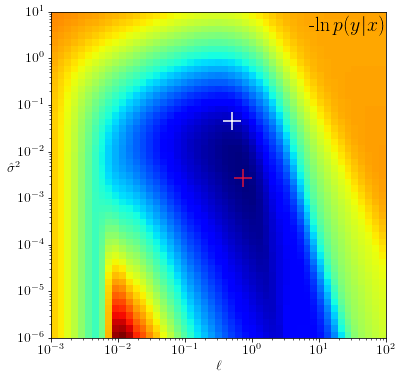

In [25]:
import numpy as np
from numpy.linalg import multi_dot as mdot
import scipy.stats
import scipy.optimize
from scipy.spatial.distance import squareform, pdist, cdist
import matplotlib.pyplot as plt
import os
from funcs import spline

os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2017/bin/x86_64-darwin'
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'cm'
plt.rcParams["font.size"] = 14

np.random.seed(20)

def f(x): #prior
    k = sf2_true * np.exp(-.5*squareform(pdist(x,'sqeuclidean')/ell_true))
    m = np.zeros(len(x))
    return np.random.multivariate_normal(m,k)

def MLII(hyperparameters): #empirical Bayesian approach known as type-II maximum likelihood
    ell = np.exp(hyperparameters[0]) ; sn2_hat = np.exp(hyperparameters[1])
    try:
        k = np.exp(-.5*squareform(pdist(x,'sqeuclidean')/ell)) + np.eye(n)*sn2_hat
        L = np.linalg.cholesky(k)
        α = np.linalg.solve(L.T,np.linalg.solve(L,y))
        sf2 = np.dot(y.T,α)/n #solve for the function variance analytically as in Sollich,2005.
        sn2 = sn2_hat*sf2
        k = sf2 * np.exp(-.5*squareform(pdist(x,'sqeuclidean')/ell)) + np.eye(n)*sn2
        L = np.linalg.cholesky(k)
        α = np.linalg.solve(L.T,np.linalg.solve(L,y))
        nlML = np.dot(y.T,α)/2 + np.log(L.diagonal()).sum() + n*np.log(2*np.pi)/2 #Algorithm 2.1 R&W
    except (np.linalg.LinAlgError) as e:
        nlML = np.inf
    return nlML

n = 100 #training points
sf2_true = 2.2 #signal variance (hyperparameter)
ell_true = 0.5 #length scale (hyperparameter)
sn2_true = 0.1 #noise variance (hyperparameter)
sn2_hat_true = sn2_true/sf2_true
#the above hyperparameters are what we would like to recover by maximising the log marginal likelihood, or
#equivalently, minimising the negative log marginal likelihood

x = np.linspace(0,5,n).reshape(n,1) #training inputs
y = f(x) + np.random.normal(0,sn2,n)

ell = np.logspace(-3,2,50)
sn2_hat = np.logspace(-6,1,50)
ell,sn2_hat = np.meshgrid(ell,sn2_hat)
nlML = np.zeros((50,50))
for ix in range(50):
    for jx in range(50):
        nlML[ix,jx] = MLII([np.log(ell[ix,jx]),np.log(sn2_hat[ix,jx])])

fig,ax = plt.subplots(1,figsize=(6,6))
plt.pcolor(ell,sn2_hat,nlML,cmap='jet')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\ell$')
plt.ylabel('$\hat\sigma^2$',rotation=0)
plt.text(7,4,'-$\ln p(y|x)$',fontsize=20)
plt.scatter(ell_true,sn2_hat_true, marker='+',color='white', s=300)
plt.scatter(ell[np.where(nlML==np.nanmin(nlML))],sn2_hat[np.where(nlML==np.nanmin(nlML))],\
            marker='+',color='crimson', s=300)
plt.show()



# Multi-Task Gaussian Process Regression (Cokriging)


In [ ]:
import numpy as np
from numpy.linalg import multi_dot as mdot
import scipy.stats
import scipy.optimize
from scipy.spatial.distance import squareform, pdist, cdist
import matplotlib.pyplot as plt
import os
from funcs import spline

os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2017/bin/x86_64-darwin'
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'cm'
plt.rcParams["font.size"] = 14

np.random.seed(20)

def nearPSD(A,epsilon=0):
    n = A.shape[0]
    eigval, eigvec = np.linalg.eig(A)
    val = np.matrix(np.maximum(eigval,epsilon))
    vec = np.matrix(eigvec)
    T = 1/(np.multiply(vec,vec) * val.T)
    T = np.matrix(np.sqrt(np.diag(np.array(T).reshape((n)) )))
    B = T * vec * np.diag(np.array(np.sqrt(val)).reshape((n)))
    out = np.asarray(B*B.T)
    return(out)

def fx(x): #prior
    k = sf2 * np.exp(-.5*squareform(pdist(x,'sqeuclidean')/ell))
    m = np.zeros(len(x))
    return np.random.multivariate_normal(m,k)

def fs(x,xs): #posterior
    kx = np.kron(Kf,sf2 * np.exp(-.5*squareform(pdist(x,'sqeuclidean')/ell)))# + np.eye(n)*sn2
    kxs = np.kron(Kf,sf2 * np.exp(-.5*cdist(xs,x,'sqeuclidean')/ell))
    kss = np.kron(Kf,sf2 * np.exp(-.5*squareform(pdist(xs,'sqeuclidean')/ell)))
    k = kss - mdot([kxs,np.linalg.inv(kx),kxs.T])
    m = mdot([kxs,np.linalg.inv(kx),y.ravel(order='F')])
    return np.random.multivariate_normal(m,k)

n = 3 #training points
ns = 100 #test points
sf2 = 1 #signal variance (hyperparameter)
ell = 0.5 #length scale (hyperparameter)
sn2 = 0.1 #noise variance (we are going to assume noise free for now)

x = np.asarray([1,1.5,4]).reshape(n,1) #training inputs
xs = np.asarray(sorted(np.random.uniform(0,5,(ns,1)))) #test inputs

#draw samples from the prior
fx1 = fx(x)
fx2 = fx(x)
fx3 = fx(x)
y1 = fx1# + np.random.normal(0,sn2,n) #let's say our outputs correspond to function fx1. (assume noise free for now)
y2 = fx2
y3 = fx3
y = np.asarray([y1,y2,y3]).T
Kf = 1 * np.exp(-.5*squareform(pdist(y.T,'sqeuclidean')/1))#nearPSD(np.abs(np.corrcoef(y.T)),epsilon=0.01)

#draw samples from the posterior
fs1 = fs(x,xs)
fs2 = fs(x,xs)
fs3 = fs(x,xs)

#generate actual mean and variance of posterior
kx = np.kron(Kf,sf2 * np.exp(-.5*squareform(pdist(x,'sqeuclidean')/ell)))# + np.eye(n)*sn2
kxs = np.kron(Kf,sf2 * np.exp(-.5*cdist(xs,x,'sqeuclidean')/ell))
kss = np.kron(Kf,sf2 * np.exp(-.5*squareform(pdist(xs,'sqeuclidean')/ell)))

fmean1 = mdot([kxs,np.linalg.inv(kx),y.ravel(order='F')])[:ns]
fvar1 = ((kss - mdot([kxs,np.linalg.inv(kx),kxs.T])).diagonal())[:ns]# + sn2
fmean2 = mdot([kxs,np.linalg.inv(kx),y.ravel(order='F')])[ns:2*ns]
fvar2 = ((kss - mdot([kxs,np.linalg.inv(kx),kxs.T])).diagonal())[ns:2*ns]
fmean3 = mdot([kxs,np.linalg.inv(kx),y.ravel(order='F')])[2*ns:]
fvar3 = ((kss - mdot([kxs,np.linalg.inv(kx),kxs.T])).diagonal())[2*ns:]


fig,ax = plt.subplots(1,figsize=(12,6))
#plt.plot(xs,fs1,color='red',lw=3.)
#plt.plot(xs,fs2,color='blue',lw=3.)
#plt.plot(xs,fs3,color='green',lw=3.)

plt.plot(xs,fmean1,color='k',lw=3.)
plt.fill_between(xs[:,0],fmean1 + 2*np.sqrt(fvar1), fmean1 - 2*np.sqrt(fvar1),\
                color='k',alpha=0.2,linewidths=0.0)
plt.plot(xs,fmean2,color='crimson',lw=3.)
plt.fill_between(xs[:,0],fmean2 + 2*np.sqrt(fvar2), fmean2 - 2*np.sqrt(fvar2),\
                color='crimson',alpha=0.2,linewidths=0.0)
plt.plot(xs,fmean3,color='green',lw=3.)
plt.fill_between(xs[:,0],fmean3 + 2*np.sqrt(fvar3), fmean3 - 2*np.sqrt(fvar3),\
                color='green',alpha=0.2,linewidths=0.0)

plt.scatter(x,y[:,0],color='k')
plt.scatter(x,y[:,1],color='crimson')
plt.scatter(x,y[:,2],color='green')
plt.show()

In [ ]:
import pyGPs
import numpy as np
import matplotlib.pyplot as plt
import os

os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2017/bin/x86_64-darwin'
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'cm'
plt.rcParams["font.size"] = 18

#synthetic GP example:
np.random.seed(123)
def f(x):
    from scipy.spatial.distance import pdist,squareform
    A = squareform(pdist(x/np.exp(log_ell_true), 'sqeuclidean'))
    dp = 2 * np.pi * np.sqrt(A) * np.exp(log_ell_true) / np.exp(log_p_true)
    k = np.exp(-0.5 * A) * np.cos(dp)
    m = np.dot(x,alpha_list_true)
    return np.random.multivariate_normal(m,k)

#generate synthetic data
n = 150
ns = n + 20
N = 1
σ_true = 1
log_ell_true = -2
log_p_true = 1.3
alpha_list_true = np.random.normal(0,1e-4,N)

x = np.linspace(0,5,n).reshape(n,N)
xs = np.linspace(0,6,ns).reshape(ns,N)
f_x = f(x).reshape(n,N)
f_xs = f(xs).reshape(ns,N)
f_xs2 = f(xs).reshape(ns,N)
f_xs3 = f(xs).reshape(ns,N)
y = (f_x[:,0] + np.random.normal(0,σ_true,n)).reshape(n,N)


#model and learn hyperparameters
model = pyGPs.GPR()
μprior = pyGPs.mean.Linear(D=N,alpha_list=[0]*N) #initialise hyperparameters=0
Σprior = pyGPs.cov.Gabor(log_ell=0,log_p=0)
model.setPrior(mean=μprior,kernel=Σprior)
model.optimize(x,y) #optimise hyperparameters and get posterior
ys = model.predict(xs)

plt.figure(figsize=(12,6))
ax = plt.gca()
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.plot(x, y, 'k.', markersize=8, label='obs')
ax.plot(x[:,0],f_x[:,0], 'b', linewidth=2, label='f(x)')
#ax.plot(xs[:,0],f_xs[:,0], 'crimson', linewidth=2,)
#ax.plot(xs[:,0],f_xs2[:,0], 'deepskyblue', linewidth=2,)
#ax.plot(xs[:,0],f_xs3[:,0], 'darkviolet', linewidth=2,)
ax.plot(xs, ys[0], color=[ 0.2109375, 0.63385, 0.1796875, 1.0], ls='-', lw=3.,label='$\mu_{f_*}$')
ax.fill_between(xs[:,0],ys[0][:,0] + 2.*np.sqrt(ys[1][:,0]), ys[0][:,0] - 2.*np.sqrt(ys[1][:,0]),\
                facecolor=[0.7539, 0.89453125, 0.62890625, 1.0],linewidths=0.0,label='$\sigma^2_{f_*}$')
ax.set_xlabel('x')
ax.set_ylabel('y', rotation=0, labelpad=15)
plt.legend(loc='lower right')
plt.ylim(-6,5)
plt.xlim(-0.25,6)
plt.show()



# Probabilistic Principle Component Analysis

In [ ]:
#Testing approximations to speed up computations (section 3 Bonilla et al, 2008)
#Probabilistic-PCA
import time

np.random.seed(3)

def nearPSD(A,epsilon=0):
    n = A.shape[0]
    eigval, eigvec = np.linalg.eigh(A)
    val = np.matrix(np.maximum(eigval,epsilon))
    vec = np.matrix(eigvec)
    T = 1/(np.multiply(vec,vec) * val.T)
    T = np.matrix(np.sqrt(np.diag(np.array(T).reshape((n)) )))
    B = T * vec * np.diag(np.array(np.sqrt(val)).reshape((n)))
    return np.asarray(B*B.T)

N,M = y.shape #N = number of observations, M = number of tasks
Kx = np.linalg.multi_dot([X,1e-8*scipy.linalg.expm(1e-20*Adj),X.T])
Kf = nearPSD(np.abs(np.corrcoef(y.T)),epsilon=0.01)
#Kf = np.ones((M,M))

t1 = time.time()
Λf, Uf = np.linalg.eigh(Kf)
Λx, Ux = np.linalg.eigh(Kf)

P = 2 #number of principal eigenvectors to use (i.e the ones that contribute the most %variance of the input)
σ = (1/(M-P))*sum(Λf[:P-1]) #eq 8 Tipping and Bishop, 1999
Uf = Uf[:,-P:]
Λf = np.diag(Λf[-P:])
L_tilde = np.dot(np.dot(Uf,scipy.linalg.sqrtm(Λf-np.eye(P)*σ)),np.eye(P)) #eq 7 Tipping and Bishop,1999
#Kf_tilde = np.dot(L_tilde,L_tilde.T) + σ*np.eye(M)
B = np.kron(L_tilde,Kx)

sn2 = np.random.rand(M)
Δ = np.kron(np.eye(M)*sn2,np.eye(N))
Δ_i = np.diag(1/Δ.diagonal())
Σ = np.kron(Kf,Kx) + Δ
#Σ_tilde = np.kron(Kf_tilde,Kx) + Δ

L = np.linalg.cholesky(np.kron(np.eye(P),Kx)+np.linalg.multi_dot([B.T,Δ_i,B]))
A = np.linalg.solve(L.T,np.linalg.solve(L,np.dot(B.T,Δ_i)))

Σ_tilde_i = Δ_i - np.linalg.multi_dot([Δ_i,B,A]) #Woodbury, Sherman and Morrison formula (matrix inversion lemma)

print(Σ_tilde_i[0,:10])
print('elapsed time for approximation method = ',time.time()-t1)

